In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import pickle
import numpy as np
from sortedcontainers import SortedDict
from scipy.ndimage.filters import gaussian_filter
from scipy.spatial import KDTree
from tqdm import tqdm
from PIL import Image
from pathlib import Path

# Paths to the dataset directories
image_dir = Path("dataset/val/images")
annotation_dir = Path("dataset/val/annotations")

# Ensure these files will be saved in the right place
gaussian_kernels_path = "gaussian_kernels.pkl"
distances_path = "distances.pkl"

# Function to generate Gaussian kernels
def generate_gaussian_kernels(min_sigma=1, max_sigma=50, num_kernels=200):
    kernels_dict = SortedDict()
    for sigma in np.linspace(min_sigma, max_sigma, num_kernels):
        size = int(6 * sigma + 1)
        kernel = np.zeros((size, size))
        center = size // 2
        kernel[center, center] = 1
        kernel = gaussian_filter(kernel, sigma)
        kernels_dict[sigma] = kernel
    return kernels_dict

def get_gt_dots(ann_path, img_height, img_width, mode="train"):
    """
    Load annotations and return as numpy array of ground truth points.
    """
    txt_list = open(ann_path, 'r').readlines()
    gt = format_label(mode, txt_list)
    assert gt.shape[1] == 3
    gt[:, 0] = gt[:, 0].clip(0, img_width - 1)
    gt[:, 1] = gt[:, 1].clip(0, img_height - 1)
    return gt

def format_label(mode, txt_list):
    format_data = []
    for idx, i in enumerate(txt_list):
        coord_raw = [int(x) for x in i.replace("\n", "").split(',') if len(x) != 0]
        coord = coord_raw[:6]
        if len(coord) != 6 or coord[2] <= 0 or coord[3] <= 0 or not 0 < coord[-1] < 11:
            continue
        if mode == "val" and int(coord[-2]) == 0 or int(coord_raw[-2]) == 2:
            continue
        bbox_left, bbox_top = coord[0], coord[1]
        bbox_right, bbox_bottom = coord[0] + coord[2], coord[1] + coord[3]
        center_x, center_y = int((bbox_left + bbox_right) * 0.5), int((bbox_top + bbox_bottom) * 0.5)
        format_data.append([center_x, center_y, coord[-1] - 1])
    return np.array(format_data)

# Collect all ground truth points and calculate distances for all images
images_annotations = {}
for ann_file in tqdm(annotation_dir.glob("*.txt"), desc="Processing Annotations"):
    img_name = ann_file.stem + ".jpg"
    img_path = image_dir / img_name
#     print(img_path)
    if not img_path.exists():
        continue
    
    # Load image to get dimensions
    img = Image.open(img_path)
    img_width, img_height = img.size
    
    # Get ground truth points for this image
    gt_points = get_gt_dots(ann_file, img_height, img_width)
    images_annotations[img_name] = gt_points

# Save Gaussian kernels
kernels_dict = generate_gaussian_kernels(min_sigma=1, max_sigma=20)
with open(gaussian_kernels_path, 'wb') as f:
    pickle.dump(kernels_dict, f)

# Calculate and save distances for each image's annotations
distances_dict = {}
for img_name, gt_points in tqdm(images_annotations.items(), desc="Calculating Distances"):
    img_path = image_dir / img_name
    if len(gt_points) < 2:
        distances_dict[img_path] = np.array([0])
    else:
        tree = KDTree(gt_points[:, :2])
        distances, _ = tree.query(gt_points[:, :2], k=11)
        distances_dict[img_path] = distances

# Save distances
with open(distances_path, 'wb') as f:
    pickle.dump(distances_dict, f)

print("Gaussian kernels and distances saved successfully.")

C:\Users\vibha\AppData\Local\Temp\ipykernel_19692\2926161880.py:5: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter
Processing Annotations: 6471it [00:03, 1871.72it/s]
Calculating Distances: 100%|█████████████████████████████████████████████████████| 6471/6471 [00:00<00:00, 8296.37it/s]


Gaussian kernels and distances saved successfully.


In [3]:
import os
import cv2
import glob
import h5py
import scipy
import pickle
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sortedcontainers import SortedDict
from scipy.ndimage.filters import gaussian_filter
from scipy.spatial import KDTree
from pathlib import WindowsPath
from itertools import islice

def generate_density_map_for_image(img_path, ann_path, precomputed_kernels_path, precomputed_distances_path, 
                                    showden=False, img_affix=".jpg", min_sigma=0, max_sigma=20, 
                                   method=3, const_sigma=15, mode="train"):
    """
    Generates a density map for a single image and saves it in the specified directory.
    Parameters:
    - img_path: Path to the image file.
    - ann_path: Path to the annotation file.
    - precomputed_kernels_path: Path to the precomputed Gaussian kernels file.
    - precomputed_distances_path: Path to the precomputed distances file.
    - ground_truth_dir: Directory where the density map will be saved.
    - showden: Whether to display the density map (for debugging/visualization).
    - img_affix: Image file suffix.
    - min_sigma, max_sigma, method, const_sigma: Parameters for density map generation.
    - mode: Dataset mode (train/val/test).
    """
    # Ensure the ground truth directory exists
#     os.makedirs(ground_truth_dir, exist_ok=True)
    
    # Load precomputed kernels and distances
    with open(precomputed_kernels_path, 'rb') as f:
        kernels_dict = pickle.load(f)
        kernels_dict = SortedDict(kernels_dict)
        
    with open(precomputed_distances_path, 'rb') as f:
        distances_dict = pickle.load(f)
        
    # Load image and annotations
    img = Image.open(img_path)
    width, height = img.size
    gt_points = get_gt_dots(ann_path, height, width, mode=mode)
    
    key = WindowsPath(img_path)
    distances = distances_dict.get(key)
    density_map = gaussian_filter_density(gt_points, height, width, distances,
                                          kernels_dict, min_sigma=min_sigma, method=method,
                                          const_sigma=const_sigma)
    return density_map

def gaussian_filter_density(non_zero_points, map_h, map_w, distances=None, kernels_dict=None, min_sigma=2, method=1,
                            const_sigma=15):
    """
    Generates a density map using Gaussian filters based on point coordinates.
    """
    gt_count = non_zero_points.shape[0]
    density_map = np.zeros((map_h, map_w), dtype=np.float32)

    for i in range(gt_count):
        point_x, point_y, category = non_zero_points[i]
        sigma = compute_sigma(gt_count, distances[i], min_sigma=min_sigma, method=method, fixed_sigma=const_sigma)
        closest_sigma = find_closest_key(kernels_dict, sigma)
        kernel = kernels_dict[closest_sigma]
        full_kernel_size = kernel.shape[0]
        kernel_size = full_kernel_size // 2

        min_img_x = max(0, point_x - kernel_size)
        min_img_y = max(0, point_y - kernel_size)
        max_img_x = min(point_x + kernel_size + 1, map_w - 1)
        max_img_y = min(point_y + kernel_size + 1, map_h - 1)

        kernel_x_min = kernel_size - point_x if point_x <= kernel_size else 0
        kernel_y_min = kernel_size - point_y if point_y <= kernel_size else 0
        kernel_x_max = kernel_x_min + max_img_x - min_img_x
        kernel_y_max = kernel_y_min + max_img_y - min_img_y

        density_map[min_img_y:max_img_y, min_img_x:max_img_x] += kernel[kernel_y_min:kernel_y_max,
                                                                 kernel_x_min:kernel_x_max]
    return density_map

def compute_sigma(gt_count, distance=None, min_sigma=1, method=1, fixed_sigma=15):
    """
    Compute sigma for the Gaussian kernel.
    """
    if gt_count > 1 and distance is not None:
        if method == 1:
            sigma = np.mean(distance[1:11]) * 0.3
        elif method == 2:
            sigma = distance[1]
        elif method == 3:
            sigma = fixed_sigma
    else:
        sigma = fixed_sigma
    if sigma < min_sigma:
        sigma = min_sigma
    return sigma

def find_closest_key(sorted_dict, key):
    """
    Finds the closest key in sorted_dict to the given key.
    """
    keys = list(islice(sorted_dict.irange(minimum=key), 1))
    keys.extend(islice(sorted_dict.irange(maximum=key, reverse=True), 1))
    return min(keys, key=lambda k: abs(key - k))


C:\Users\vibha\AppData\Local\Temp\ipykernel_19692\2466722627.py:11: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


## Model_1_SACNN

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SACNN(nn.Module):
    def __init__(self):
        super(SACNN, self).__init__()
        
        # Block 1
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        )
        
        # Block 2
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        )
        
        # Block 3
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        )
        
        # Block 4
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        )
        
        # Block 5
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        )
        
        # Block 6
        self.block6_conv1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu6 = nn.ReLU(inplace=True)
        
        # Deconvolution and Upsample
        self.deconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2, padding=0)
        self.deconv2 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2, padding=0)
        
        # Final Block
        self.sacnn7_conv1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.sacnn7_conv2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.sacnn7_conv3 = nn.Conv2d(256, 1, kernel_size=1)
    
    def forward(self, x):
        # Block 1
        x11 = self.block1(x)
        # print("Block 1 output shape:", x11.shape)
        # Block 2
        x21 = self.block2(x11)
        # print("Block 2 output shape:", x21.shape)
        # Block 3
        x31 = self.block3(x21)
        # print("Block 3 output shape:", x31.shape)
        # Block 4
        x41 = self.block4(x31)
        # print("Block 4 output shape:", x41.shape)
        # Block 5
        x51 = self.block5(x41)
        # print("Block 5 output shape:", x51.shape)
        # Block 6
        x61 = self.relu6(self.block6_conv1(x51))
        # print("Block 6 output shape:", x61.shape)
        x6153 = torch.cat([x51, x61], dim=1)
        # print("Concatenation output shape (x51, x61):", x6153.shape)
        # Deconvolution and Upsample
        xd = self.deconv1(x6153)
        # print("Deconv1 output shape:", xd.shape)
        # Upsample x41 to match xd's dimensions
        x41_upsampled = F.interpolate(x41, size=(xd.shape[2], xd.shape[3]), mode='bilinear', align_corners=False)
        # print("Upsampled x41 shape:", x41_upsampled.shape)
        xd43 = torch.cat([xd, x41_upsampled], dim=1)
        # print("Concatenation output shape (xd, x41_upsampled):", xd43.shape)
        xd43 = self.deconv2(xd43)
        # print("Deconv2 output shape:", xd43.shape)
        # Final Block
        x71 = self.sacnn7_conv1(xd43)
        # print("Final Block conv1 output shape:", x71.shape)
        x72 = self.sacnn7_conv2(x71)
        # print("Final Block conv2 output shape:", x72.shape)
        x73 = self.sacnn7_conv3(x72)
        # print("Final Block conv3 output shape:", x73.shape)
        return x73

# Test the model with random input
model = SACNN()
random_image = torch.rand(1, 1, 540, 480)  # (batch, channels, height, width)
output = model(random_image)
print(f"Output shape: {output.shape}")


Output shape: torch.Size([1, 1, 140, 124])


In [7]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

def get_image_annotation_pairs(images_dir, annotations_dir):
    """
    Fetches pairs of image and annotation file paths.
    """
    image_annotation_pairs = []
    image_files = [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]

    for img_file in image_files:
        img_name, img_ext = os.path.splitext(img_file)
        ann_file = img_name + '.txt'
        
        img_path = os.path.join(images_dir, img_file)
        ann_path = os.path.join(annotations_dir, ann_file)

        if os.path.exists(ann_path):
            image_annotation_pairs.append((img_path, ann_path))
        else:
            print(f"No annotation found for {img_file}")

    return image_annotation_pairs

def process_images(img_path, ann_path, downsample=4):
    """
    Loads and processes an image and its corresponding annotation to create the downsampled ground truth density map.
    Returns the processed image and density map as numpy arrays in grayscale.
    """
    img = plt.imread(img_path)
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    precomputed_distances_path = 'distances.pkl'
    precomputed_kernels_path = 'gaussian_kernels.pkl'
    gt_dmap = generate_density_map_for_image(img_path, ann_path, precomputed_kernels_path, precomputed_distances_path)
    height, width = img.shape[:2]
    img = cv2.resize(img, (downsample * (width // downsample),downsample * (height // downsample)))
    gt_dmap = cv2.resize(gt_dmap, (width // downsample, height // downsample))
    img = np.expand_dims(img, axis=-1).astype(np.float32) 
    gt_dmap = np.expand_dims(gt_dmap, axis=-1).astype(np.float32)
    return img, gt_dmap

# Define dataset class
class CrowdDataset(Dataset):
    def __init__(self, img_ann_pairs, gt_downsample=4):
        """
        Dataset for loading images and downsampled density maps.
        """
        self.img_ann_pairs = img_ann_pairs
        self.gt_downsample = gt_downsample

    def __len__(self):
        return len(self.img_ann_pairs)

    def __getitem__(self, idx):
        img_path, ann_path = self.img_ann_pairs[idx]
        img, gt_dmap = process_images(img_path, ann_path, self.gt_downsample)
        return img, gt_dmap

# Custom Euclidean Loss Function
def euclidean_loss(preds, gt):
    return torch.mean((preds - gt) ** 2)

# Replace `criterion` with the custom loss function
criterion = euclidean_loss


In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Set paths
train_img_root = 'dataset/val/images'
train_ann_root = 'dataset/val/annotations'
checkpoint_path = './checkpoints/last_checkpoint.pth'

# Training parameters
total_epochs = 250
epochs_per_session = 10
start_epoch = 0
lr = 1e-6
momentum = 0.9
batch_size = 1

# Create checkpoint directory
os.makedirs('./checkpoints', exist_ok=True)

# Model setup
sacnn = SACNN().to(device)
optimizer = optim.SGD(sacnn.parameters(), lr=lr, momentum=momentum)

# Load checkpoint if it exists
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    sacnn.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Loaded checkpoint from {checkpoint_path}")
else:
    print("No checkpoint found, starting from scratch.")

# Get image-annotation pairs and create dataset
img_ann_pairs = get_image_annotation_pairs(train_img_root, train_ann_root)
train_dataset = CrowdDataset(img_ann_pairs, gt_downsample=4)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training step
def train_step(images, gt_dmap):
    images, gt_dmap = images.to(device), gt_dmap.to(device)
    optimizer.zero_grad()
    
    preds = sacnn(images)
    preds_resized = torch.nn.functional.interpolate(preds, size=gt_dmap.shape[2:], mode="bilinear", align_corners=False)
    loss = criterion(preds_resized, gt_dmap)
    
    loss.backward()
    optimizer.step()
    return loss.item()

# Training loop with tqdm progress bar
for epoch in range(start_epoch, total_epochs):
    print(f"Starting epoch {epoch + 1}/{total_epochs}")
    sacnn.train()  # Set the model to training mode
    total_loss = 0.0

    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{total_epochs}", unit="batch") as pbar:
        for images, gt_dmap in train_loader:
            # Move inputs to correct dimensions and types if needed
            images = images.permute(0, 3, 1, 2)  # Change (batch, H, W, C) to (batch, C, H, W)
            gt_dmap = gt_dmap.permute(0, 3, 1, 2)
            
            images, gt_dmap = images.to(device), gt_dmap.to(device)
            loss = train_step(images, gt_dmap)
            total_loss += loss
            pbar.set_postfix(loss=loss)
            pbar.update(1)
    
    avg_epoch_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{total_epochs}] - Loss: {avg_epoch_loss:.4f}")

    # Save checkpoint every few epochs
    if (epoch + 1) % epochs_per_session == 0:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': sacnn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_epoch_loss
        }
        torch.save(checkpoint, f'./checkpoints/epoch_{epoch + 1}.pth')
        print(f"Checkpoint saved at epoch {epoch + 1}")

# Save the final model
torch.save(sacnn.state_dict(), './checkpoints/final_model.pth')
print("Final model saved.")

Device: cuda
No checkpoint found, starting from scratch.
Starting epoch 1/250


Epoch 1/250:  19%|████████▏                                  | 1233/6471 [6:53:50<29:18:05, 20.14s/batch, loss=0.00198]


KeyboardInterrupt: 

## Model_2_MCNN

In [12]:
import torch
import torch.nn as nn


class MCNN(nn.Module):
    '''
    Implementation of Multi-column CNN for crowd counting
    '''
    def __init__(self,load_weights=False):
        super(MCNN,self).__init__()

        self.branch1=nn.Sequential(
            nn.Conv2d(3,16,9,padding=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(16,32,7,padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32,16,7,padding=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(16,8,7,padding=3),
            nn.ReLU(inplace=True)
        )

        self.branch2=nn.Sequential(
            nn.Conv2d(3,20,7,padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(20,40,5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(40,20,5,padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(20,10,5,padding=2),
            nn.ReLU(inplace=True)
        )

        self.branch3=nn.Sequential(
            nn.Conv2d(3,24,5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(24,48,3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(48,24,3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(24,12,3,padding=1),
            nn.ReLU(inplace=True)
        )

        self.fuse=nn.Sequential(nn.Conv2d(30,1,1,padding=0))

        if not load_weights:
            self._initialize_weights()

    def forward(self,img_tensor):
        x1=self.branch1(img_tensor)
        x2=self.branch2(img_tensor)
        x3=self.branch3(img_tensor)
        x=torch.cat((x1,x2,x3),1)
        x=self.fuse(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


# test code
if __name__=="__main__":
    img=torch.rand((1,3,800,1200),dtype=torch.float)
    mcnn=MCNN()
    out_dmap=mcnn(img)
    print(out_dmap.shape)

torch.Size([1, 1, 200, 300])


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

def get_image_annotation_pairs(images_dir, annotations_dir):
    image_annotation_pairs = []

    image_files = [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]
    for img_file in image_files:
        img_name, img_ext = os.path.splitext(img_file)
        ann_file = img_name + '.txt'
        
        img_path = os.path.join(images_dir, img_file)
        ann_path = os.path.join(annotations_dir, ann_file)

        if os.path.exists(ann_path):
            image_annotation_pairs.append((img_path, ann_path))
        else:
            print(f"No annotation found for {img_file}")

    return image_annotation_pairs

def process_images(img_path, ann_path, downsample=4):
    img = plt.imread(img_path)
    if len(img.shape) == 2:
        img = np.stack((img,) * 3, axis=-1)
    gt_dmap = generate_density_map_for_image(img_path, ann_path, precomputed_kernels_path, precomputed_distances_path)
    height, width = img.shape[:2]
    img = cv2.resize(img, (width, height))
    gt_dmap = cv2.resize(gt_dmap, (width // downsample, height // downsample))
    img_tensor = torch.tensor(img.transpose((2, 0, 1)), dtype=torch.float)
    gt_dmap_tensor = torch.tensor(gt_dmap, dtype=torch.float).unsqueeze(0)
    return img_tensor, gt_dmap_tensor

# Define dataset class
class CrowdDataset(Dataset):
    def __init__(self, img_ann_pairs, gt_downsample=4):
        self.img_ann_pairs = img_ann_pairs
        self.gt_downsample = gt_downsample

    def __len__(self):
        return len(self.img_ann_pairs)

    def __getitem__(self, idx):
        img_path, ann_path = self.img_ann_pairs[idx]
        img, gt_dmap = process_images(img_path, ann_path, self.gt_downsample)
        return img, gt_dmap


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import os
from tqdm import tqdm
import visdom

# Initialize Visdom
vis = visdom.Visdom()
device = torch.device('cuda')

# Set paths
train_img_root = 'dataset/val/images'
train_ann_root = 'dataset/val/annotations'
precomputed_kernels_path = 'gaussian_kernels.pkl'
precomputed_distances_path = 'distances.pkl'

# Training parameters
total_epochs = 100  # Total epochs to train
epochs_per_session = 10  # Number of epochs to train per Kaggle session
start_epoch = 0  # Initial start epoch
lr = 1e-6
momentum = 0.95
gt_downsample = 4
batch_size = 1
checkpoint_path = './checkpoints/last_checkpoint.param'
  # Path to save checkpoint

# Create checkpoint directory
os.makedirs('./checkpoints', exist_ok=True)

# Model, criterion, and optimizer
mcnn = MCNN().to(device)
criterion = nn.MSELoss(reduction='sum').to(device)
optimizer = optim.SGD(mcnn.parameters(), lr=lr, momentum=momentum)

# Load checkpoint if exists
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    mcnn.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # Continue from next epoch
    print(f"Loaded checkpoint from epoch {start_epoch}")
else:
    print("No checkpoint found, starting from scratch.")

# Dataset and Dataloader setup
img_ann_pairs = get_image_annotation_pairs(train_img_root, train_ann_root)
dataset = CrowdDataset(img_ann_pairs, gt_downsample)
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(start_epoch, min(start_epoch + epochs_per_session, total_epochs)):
    mcnn.train()
    epoch_loss = 0.0
    
    with tqdm(total=len(train_dataloader), desc=f"Epoch [{epoch + 1}/{total_epochs}]", unit="batch") as pbar:
        for i, (img, gt_dmap) in enumerate(train_dataloader):
            img, gt_dmap = img.to(device), gt_dmap.to(device)
            optimizer.zero_grad()

            # Forward pass
            et_dmap = mcnn(img)
            loss = criterion(et_dmap, gt_dmap)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
            pbar.update(1)
    
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch [{epoch + 1}/{total_epochs}] - Total Loss: {epoch_loss:.4f}, Average Loss: {avg_epoch_loss:.4f}")
    
    # Save checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': mcnn.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save({
        'epoch': epoch,
        'model_state_dict': mcnn.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_epoch_loss,
    }, f'./checkpoints/epoch_{epoch}.param')
    
    print(f"Checkpoint saved at epoch {epoch + 1}")

# To continue training, you would "Save and Commit" the notebook on Kaggle,
# then run it again to continue from the last saved checkpoint.


Setting up a new session...


Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "C:\Users\vibha\Downloads\DMNet-master\ee798\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "C:\Users\vibha\Downloads\DMNet-master\ee798\lib\site-packages\urllib3\util\connection.py", line 95, in create_connection
    raise err
  File "C:\Users\vibha\Downloads\DMNet-master\ee798\lib\site-packages\urllib3\util\connection.py", line 85, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\vibha\Downloads\DMNet-master\ee798\lib\site-packages\urllib3\connectionpool.py", line 716, in urlopen
    httplib_response = self._make_request(
  File "C:\Users\vibha\Downloads\DMNet-master\ee798\lib\site-packages\urllib3\connectionpool.py", line 416, in _make_request
    co

No checkpoint found, starting from scratch.


Epoch [1/100]:   0%|                                                  | 16/6471 [00:05<38:21,  2.81batch/s, loss=0.972]


KeyboardInterrupt: 

## Object_Detection_YOLOv5

In [3]:
!pip install ultralytics
!pip install -U matplotlib  # Optional for better visualization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.6/876.6 kB 16.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 49.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.5
    Uninstalling matplotlib-3.7.5:
      Successfully uninstalled matplotlib-3.7.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 2024.66.154055 requires jupyterlab~=3.6.0, but you have jupyterlab 4.2.5 which is incompatible.
ydata-profiling 4.10.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.1 which is incompatible.


In [5]:
import os
from pathlib import Path
from ultralytics.utils.downloads import download

# Define the dataset path
dataset_path = '../datasets/VisDrone'
train_images = os.path.join(dataset_path, 'VisDrone2019-DET-train/images')
val_images = os.path.join(dataset_path, 'VisDrone2019-DET-val/images')
test_images = os.path.join(dataset_path, 'VisDrone2019-DET-test-dev/images')

# Download and convert VisDrone dataset to YOLO format
def visdrone2yolo(dir):
    from PIL import Image
    from tqdm import tqdm

    def convert_box(size, box):
        dw = 1. / size[0]
        dh = 1. / size[1]
        return (box[0] + box[2] / 2) * dw, (box[1] + box[3] / 2) * dh, box[2] * dw, box[3] * dh

    # Ensure the labels directory exists
    (dir / 'labels').mkdir(parents=True, exist_ok=True)

    # Process all annotation files
    pbar = tqdm((dir / 'annotations').glob('*.txt'), desc=f'Converting {dir}')
    
    for f in pbar:
        img_file = (dir / 'images' / f.name).with_suffix('.jpg')
        
        # Only process if the image exists
        if img_file.exists():
            img_size = Image.open(img_file).size
            lines = []
            with open(f, 'r') as file:
                for row in [x.split(',') for x in file.read().strip().splitlines()]:
                    if row[4] == '0':  # Skip ignored regions (class 0)
                        continue
                    cls = int(row[5]) - 1
                    box = convert_box(img_size, tuple(map(int, row[:4])))
                    lines.append(f"{cls} {' '.join(f'{x:.6f}' for x in box)}\n")

            # Write all lines to the corresponding label file at once
            label_file = str(f).replace(f'{os.sep}annotations{os.sep}', f'{os.sep}labels{os.sep}')
            with open(label_file, 'w') as fl:
                fl.writelines(lines)

# Convert dataset directories
for d in ['VisDrone2019-DET-train', 'VisDrone2019-DET-val', 'VisDrone2019-DET-test-dev']:
    visdrone2yolo(Path(dataset_path) / d)


Converting ../datasets/VisDrone/VisDrone2019-DET-train: 6471it [00:04, 1361.42it/s]
Converting ../datasets/VisDrone/VisDrone2019-DET-val: 548it [00:00, 1136.17it/s]
Converting ../datasets/VisDrone/VisDrone2019-DET-test-dev: 1610it [00:01, 1372.69it/s]


In [15]:
from ultralytics import YOLO
import os

# Load the pretrained YOLOv5 model (small version)
model = YOLO('yolov5su.pt')  # Use other models like yolov5m.pt, yolov5l.pt, or yolov5x.pt for larger models

# Verify the path to the dataset YAML file
print(os.listdir('../datasets/VisDrone/'))

# Train the model, save weights every 5 epochs
model.train(data='/kaggle/input/visdrone-dataset/VisDrone.yaml', epochs=100, batch=16, imgsz=640, pretrained=True, save_period=5)


['VisDrone2019-DET-val.zip', 'VisDrone2019-DET-train.zip', 'VisDrone2019-DET-train', 'VisDrone2019-DET-test-dev', 'VisDrone2019-DET-test-dev.zip', 'VisDrone2019-DET-val']
Ultralytics 8.3.19 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov5su.pt, data=/kaggle/input/visdrone-dataset/VisDrone.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=5, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnost

train: Scanning /kaggle/working/datasets/VisDrone/VisDrone2019-DET-train/labels.cache... 6471 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6471/6471 [00:00<?, ?it/s]

train: WARNING ⚠️ /kaggle/working/datasets/VisDrone/VisDrone2019-DET-train/images/0000137_02220_d_0000163.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/datasets/VisDrone/VisDrone2019-DET-train/images/0000140_00118_d_0000002.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/datasets/VisDrone/VisDrone2019-DET-train/images/9999945_00000_d_0000114.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/datasets/VisDrone/VisDrone2019-DET-train/images/9999987_00000_d_0000049.jpg: 1 duplicate labels removed


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/datasets/VisDrone/VisDrone2019-DET-val/labels.cache... 548 images, 0 backgrounds, 0 corrupt: 100%|██████████| 548/548 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train5
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      10.5G      1.624      1.805       1.02        418        640: 100%|██████████| 405/405 [02:11<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.73it/s]


                   all        548      38759      0.309      0.236      0.197      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      8.67G       1.56      1.306     0.9699        336        640: 100%|██████████| 405/405 [02:06<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.50it/s]

                   all        548      38759      0.316      0.251      0.222      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100        12G      1.583      1.281      0.971        400        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.38it/s]

                   all        548      38759      0.348      0.259      0.242      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      9.02G      1.586       1.26     0.9713        966        640: 100%|██████████| 405/405 [02:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.48it/s]

                   all        548      38759      0.366      0.279      0.261      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100        12G      1.548      1.213     0.9612        514        640: 100%|██████████| 405/405 [02:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.47it/s]

                   all        548      38759      0.381      0.269      0.257      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      11.8G      1.529      1.181      0.952        812        640: 100%|██████████| 405/405 [02:06<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.51it/s]

                   all        548      38759       0.37      0.283      0.271      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.57G        1.5      1.154     0.9482        528        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.56it/s]

                   all        548      38759      0.399      0.295      0.287      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      9.92G      1.481      1.129     0.9445        587        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.55it/s]

                   all        548      38759      0.391      0.302      0.289      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      11.8G      1.472       1.11     0.9396        572        640: 100%|██████████| 405/405 [02:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.56it/s]

                   all        548      38759       0.39      0.305       0.29      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      9.22G      1.448      1.093     0.9366        839        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.56it/s]

                   all        548      38759      0.389      0.306      0.296      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      8.94G      1.439      1.084     0.9338        503        640: 100%|██████████| 405/405 [02:05<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.47it/s]

                   all        548      38759      0.403      0.311      0.303      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.47G      1.439      1.074     0.9313        686        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.40it/s]

                   all        548      38759      0.425      0.315      0.313       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      9.42G      1.424      1.064     0.9306        510        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.50it/s]

                   all        548      38759      0.411      0.316      0.309       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      12.7G      1.411      1.049     0.9252        586        640: 100%|██████████| 405/405 [02:06<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.62it/s]

                   all        548      38759      0.442      0.324      0.324      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      12.3G      1.407      1.042     0.9263        225        640: 100%|██████████| 405/405 [02:06<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.57it/s]

                   all        548      38759      0.434      0.327       0.32      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      11.4G        1.4      1.036     0.9222       1304        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.59it/s]

                   all        548      38759       0.44      0.329       0.33      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      10.2G      1.391      1.019     0.9234        357        640: 100%|██████████| 405/405 [02:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.57it/s]

                   all        548      38759      0.427      0.335      0.326      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      10.2G      1.385      1.019     0.9214        582        640: 100%|██████████| 405/405 [02:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.57it/s]

                   all        548      38759      0.434      0.332      0.331      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100       7.9G      1.385      1.011     0.9214        513        640: 100%|██████████| 405/405 [02:06<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.63it/s]

                   all        548      38759      0.446      0.329      0.331      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      9.16G      1.376     0.9971     0.9172        542        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.61it/s]

                   all        548      38759      0.451      0.338      0.344      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      9.81G      1.362     0.9904     0.9161        424        640: 100%|██████████| 405/405 [02:06<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.59it/s]

                   all        548      38759      0.442      0.342      0.342      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      11.2G      1.357     0.9874     0.9177        686        640: 100%|██████████| 405/405 [02:05<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.62it/s]

                   all        548      38759      0.457      0.339      0.344      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      9.97G      1.361     0.9859     0.9139        789        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.63it/s]

                   all        548      38759      0.451      0.344      0.345      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      8.76G      1.351     0.9754     0.9119        553        640: 100%|██████████| 405/405 [02:04<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.61it/s]

                   all        548      38759      0.437      0.343      0.345      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      8.49G      1.353     0.9738     0.9127        347        640: 100%|██████████| 405/405 [02:04<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.52it/s]

                   all        548      38759      0.465      0.341      0.348      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      11.2G      1.345     0.9669     0.9117        515        640: 100%|██████████| 405/405 [02:04<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.57it/s]

                   all        548      38759      0.474       0.34      0.351      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      9.45G      1.342     0.9619     0.9098        543        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.64it/s]

                   all        548      38759      0.456      0.354      0.352      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      8.45G      1.332     0.9546     0.9084        216        640: 100%|██████████| 405/405 [02:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.64it/s]

                   all        548      38759       0.47      0.346      0.354      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      13.3G      1.334     0.9523     0.9083        764        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.61it/s]

                   all        548      38759      0.471      0.346      0.357       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      9.43G      1.324     0.9457     0.9071        706        640: 100%|██████████| 405/405 [02:05<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.58it/s]

                   all        548      38759      0.459      0.347      0.352      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      10.1G      1.327     0.9445     0.9079        447        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.55it/s]

                   all        548      38759      0.475      0.352      0.365      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.55G       1.32     0.9363     0.9047        773        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.60it/s]

                   all        548      38759      0.492       0.35      0.365      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       8.7G      1.318     0.9329     0.9045        460        640: 100%|██████████| 405/405 [02:04<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.66it/s]

                   all        548      38759      0.495      0.341      0.363      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      9.57G      1.318     0.9314     0.9041        603        640: 100%|██████████| 405/405 [02:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.69it/s]

                   all        548      38759      0.475      0.357      0.365      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      9.88G      1.312     0.9256     0.9036        634        640: 100%|██████████| 405/405 [02:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.69it/s]

                   all        548      38759      0.489      0.351      0.366      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      8.62G      1.306     0.9219     0.9015        706        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.67it/s]

                   all        548      38759      0.488      0.354      0.369      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      9.36G      1.313     0.9214     0.9029        492        640: 100%|██████████| 405/405 [02:04<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.64it/s]

                   all        548      38759      0.491      0.359      0.372      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      13.3G      1.298      0.909     0.9005        699        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.59it/s]

                   all        548      38759      0.492      0.364      0.376      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      9.61G      1.298     0.9083        0.9        435        640: 100%|██████████| 405/405 [02:04<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.60it/s]

                   all        548      38759      0.493      0.362      0.374       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      8.77G      1.296     0.9054     0.9002        788        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.58it/s]


                   all        548      38759      0.493      0.356      0.373       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      8.45G      1.293     0.9014     0.8994        943        640: 100%|██████████| 405/405 [02:05<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.52it/s]

                   all        548      38759        0.5      0.362      0.377      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      9.14G      1.293      0.898     0.8982        491        640: 100%|██████████| 405/405 [02:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.56it/s]

                   all        548      38759       0.48      0.365      0.376      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      10.8G      1.283     0.8899     0.8972        828        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.65it/s]

                   all        548      38759      0.493      0.364      0.377      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      9.11G      1.285     0.8897      0.897        481        640: 100%|██████████| 405/405 [02:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.62it/s]

                   all        548      38759      0.491      0.363       0.38      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      11.9G      1.289     0.8911     0.8964        678        640: 100%|██████████| 405/405 [02:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.62it/s]

                   all        548      38759        0.5      0.367       0.38      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      9.08G      1.273     0.8817     0.8962        630        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.64it/s]

                   all        548      38759      0.498      0.368      0.381      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      12.2G      1.276     0.8809     0.8943        433        640: 100%|██████████| 405/405 [02:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.70it/s]

                   all        548      38759      0.492      0.367      0.378      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      10.9G      1.278     0.8785      0.895        583        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.69it/s]

                   all        548      38759      0.489      0.376      0.382      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      9.36G      1.263     0.8662     0.8943        509        640: 100%|██████████| 405/405 [02:04<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.66it/s]

                   all        548      38759      0.489      0.375      0.385      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      9.43G       1.27      0.871     0.8939        469        640: 100%|██████████| 405/405 [02:04<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.74it/s]

                   all        548      38759      0.496      0.369      0.387       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       9.4G      1.274     0.8725     0.8939        476        640: 100%|██████████| 405/405 [02:05<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.67it/s]

                   all        548      38759      0.494      0.375      0.385      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100        11G      1.265     0.8619      0.893        592        640: 100%|██████████| 405/405 [02:04<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.71it/s]

                   all        548      38759      0.494      0.376      0.389      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      8.66G      1.266     0.8612     0.8911        752        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.69it/s]

                   all        548      38759      0.501      0.366      0.386      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      10.6G      1.264     0.8606     0.8904        463        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.60it/s]

                   all        548      38759      0.512      0.366      0.389      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      8.82G      1.257     0.8552     0.8913        710        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.60it/s]

                   all        548      38759      0.499      0.373      0.389      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      8.82G      1.245     0.8465     0.8895        654        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.74it/s]

                   all        548      38759      0.496      0.371      0.385       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100        13G      1.254     0.8517     0.8908        684        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.57it/s]


                   all        548      38759        0.5      0.377      0.391      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      9.13G      1.246      0.843     0.8881        840        640: 100%|██████████| 405/405 [02:05<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.52it/s]

                   all        548      38759      0.499      0.373      0.389      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100        10G      1.248     0.8404       0.89        429        640: 100%|██████████| 405/405 [02:05<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.68it/s]

                   all        548      38759      0.509      0.373      0.392      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      9.47G      1.245       0.84     0.8875        423        640: 100%|██████████| 405/405 [02:05<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.69it/s]

                   all        548      38759      0.508      0.375      0.391      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      13.6G      1.241     0.8354     0.8877        576        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.68it/s]

                   all        548      38759      0.518      0.374      0.391      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      11.3G      1.238      0.832     0.8873        710        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.61it/s]

                   all        548      38759      0.496      0.377       0.39      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      9.03G      1.236     0.8316     0.8857        858        640: 100%|██████████| 405/405 [02:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.66it/s]

                   all        548      38759      0.502      0.376      0.391      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      10.8G       1.24     0.8354     0.8869        456        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.71it/s]

                   all        548      38759      0.505      0.377      0.393      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      11.6G      1.235     0.8241     0.8855        662        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.64it/s]

                   all        548      38759      0.516      0.372      0.393      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      10.2G      1.235     0.8261     0.8864        489        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.65it/s]

                   all        548      38759      0.503      0.383      0.394      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.25G      1.232     0.8214     0.8853        545        640: 100%|██████████| 405/405 [02:06<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.64it/s]

                   all        548      38759      0.515      0.376      0.396      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      9.29G      1.232       0.82     0.8857        624        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.64it/s]

                   all        548      38759      0.523      0.376      0.395      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      9.64G      1.225     0.8153     0.8845        536        640: 100%|██████████| 405/405 [02:04<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.64it/s]

                   all        548      38759       0.52      0.376      0.396      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100        11G      1.224     0.8097     0.8844        504        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.67it/s]

                   all        548      38759      0.514       0.38      0.397      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       8.1G      1.226     0.8104     0.8838        448        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.70it/s]

                   all        548      38759       0.52      0.374      0.396      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      9.14G      1.223     0.8096     0.8831        599        640: 100%|██████████| 405/405 [02:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.70it/s]

                   all        548      38759        0.5      0.383      0.394      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      9.09G      1.216     0.7998     0.8818        567        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.58it/s]


                   all        548      38759      0.516      0.376      0.397      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      8.62G      1.214     0.8011      0.883        507        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.57it/s]


                   all        548      38759       0.51      0.381      0.398      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      11.3G      1.214     0.7971     0.8825        429        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.58it/s]

                   all        548      38759      0.511      0.382      0.398      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      9.03G      1.214      0.797     0.8808        727        640: 100%|██████████| 405/405 [02:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.65it/s]

                   all        548      38759      0.517      0.376      0.396      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100        12G      1.218     0.7979     0.8808        314        640: 100%|██████████| 405/405 [02:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.62it/s]

                   all        548      38759       0.51      0.382      0.398      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      9.45G      1.211     0.7908     0.8785        337        640: 100%|██████████| 405/405 [02:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.67it/s]

                   all        548      38759      0.506      0.387        0.4      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      10.4G      1.203     0.7858     0.8791        511        640: 100%|██████████| 405/405 [02:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.68it/s]

                   all        548      38759      0.517      0.382      0.399      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      10.1G      1.204      0.783     0.8802        509        640: 100%|██████████| 405/405 [02:05<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.71it/s]

                   all        548      38759      0.507      0.388      0.399      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      9.38G      1.201     0.7821     0.8787        538        640: 100%|██████████| 405/405 [02:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.60it/s]

                   all        548      38759      0.513      0.387        0.4      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      9.51G      1.192     0.7746     0.8785        607        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]

                   all        548      38759       0.52      0.387      0.401      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      9.76G      1.196     0.7747     0.8771        630        640: 100%|██████████| 405/405 [02:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.68it/s]

                   all        548      38759      0.518      0.385        0.4      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      9.79G      1.195     0.7722     0.8766        454        640: 100%|██████████| 405/405 [02:04<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.69it/s]

                   all        548      38759      0.516      0.383      0.398      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       7.2G      1.192     0.7703      0.877        530        640: 100%|██████████| 405/405 [02:06<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.57it/s]

                   all        548      38759      0.516      0.384        0.4      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      8.33G      1.195     0.7695     0.8762        354        640: 100%|██████████| 405/405 [02:06<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.46it/s]

                   all        548      38759      0.524      0.381      0.401      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      11.6G      1.186     0.7635      0.876        512        640: 100%|██████████| 405/405 [02:08<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]


                   all        548      38759      0.518      0.384      0.401      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      10.6G      1.189     0.7603     0.8759        590        640: 100%|██████████| 405/405 [02:04<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.69it/s]

                   all        548      38759      0.522      0.383      0.401      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      9.73G      1.182     0.7582     0.8743        480        640: 100%|██████████| 405/405 [02:04<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.58it/s]

                   all        548      38759      0.512      0.386        0.4      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      8.44G      1.179     0.7539     0.8749        544        640: 100%|██████████| 405/405 [02:04<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.83it/s]

                   all        548      38759      0.513      0.386      0.401      0.238


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      8.54G      1.173     0.7396     0.8756        435        640: 100%|██████████| 405/405 [01:57<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.74it/s]

                   all        548      38759      0.507      0.384      0.397      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      9.71G      1.167     0.7299      0.874        281        640: 100%|██████████| 405/405 [01:57<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.74it/s]

                   all        548      38759      0.503      0.384      0.396      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      8.87G      1.154     0.7202      0.872        114        640: 100%|██████████| 405/405 [01:56<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]

                   all        548      38759      0.518      0.377      0.395      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      9.92G      1.153     0.7163     0.8719        289        640: 100%|██████████| 405/405 [01:56<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]

                   all        548      38759      0.512      0.382      0.396      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      10.6G      1.146     0.7128     0.8714        298        640: 100%|██████████| 405/405 [01:57<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]

                   all        548      38759      0.516      0.381      0.395      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      9.47G      1.145     0.7101     0.8704        166        640: 100%|██████████| 405/405 [01:57<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.68it/s]

                   all        548      38759      0.508      0.381      0.396      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      10.9G      1.145     0.7078     0.8708        279        640: 100%|██████████| 405/405 [01:56<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.84it/s]

                   all        548      38759      0.512      0.378      0.395      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      9.37G       1.14     0.7031     0.8698        362        640: 100%|██████████| 405/405 [01:56<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.85it/s]

                   all        548      38759      0.513      0.377      0.395      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      9.92G      1.136     0.6995     0.8682        228        640: 100%|██████████| 405/405 [01:56<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]

                   all        548      38759      0.512      0.381      0.396      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      10.5G      1.137     0.6982     0.8686        294        640: 100%|██████████| 405/405 [01:57<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]

                   all        548      38759       0.51      0.382      0.395      0.234



100 epochs completed in 3.632 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 18.5MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 18.5MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.19 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLOv5s summary (fused): 193 layers, 9,115,406 parameters, 0 gradients, 23.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:10<00:00,  1.73it/s]


                   all        548      38759      0.518      0.386      0.399      0.239
            pedestrian        520       8844      0.529       0.39      0.425      0.193
                people        482       5125      0.587      0.275      0.337       0.13
               bicycle        364       1287       0.31      0.155       0.13     0.0526
                   car        515      14064      0.722      0.769      0.796      0.566
                   van        421       1975      0.536      0.446      0.455      0.322
                 truck        266        750      0.526      0.353      0.374      0.252
              tricycle        337       1045      0.419      0.298      0.288      0.158
       awning-tricycle        220        532      0.348      0.205      0.181      0.113
                   bus        131        251      0.691      0.518      0.562      0.412
                 motor        485       4886      0.513      0.447      0.446      0.195
Speed: 0.1ms preproce

lr/pg0,▃███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▁▁▁
lr/pg1,▃████▇▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▃▃▂▂▂▂▂▂▂▂▁▁
lr/pg2,▆███▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁
metrics/mAP50(B),▁▂▄▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇█▇████████████████
metrics/mAP50-95(B),▁▂▃▃▃▅▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████████████████
metrics/precision(B),▁▂▃▃▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███▇█▇█████▇██
metrics/recall(B),▁▂▄▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██▇███████████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▇▆▆▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cb7927d0c40>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0


image 1/1 /kaggle/working/../datasets/VisDrone/VisDrone2019-DET-val/images/0000301_01001_d_0000161.jpg: 384x640 3 pedestrians, 1 people, 27 cars, 2 vans, 1 truck, 1 tricycle, 1 bus, 1 motor, 10.5ms
Speed: 3.0ms preprocess, 10.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/train54


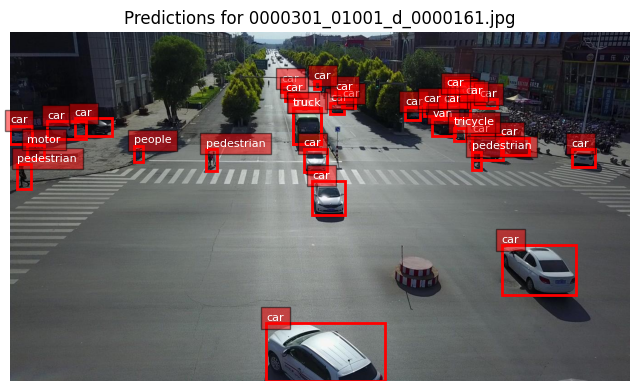


image 1/1 /kaggle/working/../datasets/VisDrone/VisDrone2019-DET-val/images/0000312_00201_d_0000415.jpg: 384x640 25 pedestrians, 1 people, 1 bicycle, 56 cars, 2 vans, 3 trucks, 2 tricycles, 5 motors, 9.8ms
Speed: 2.1ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/train55


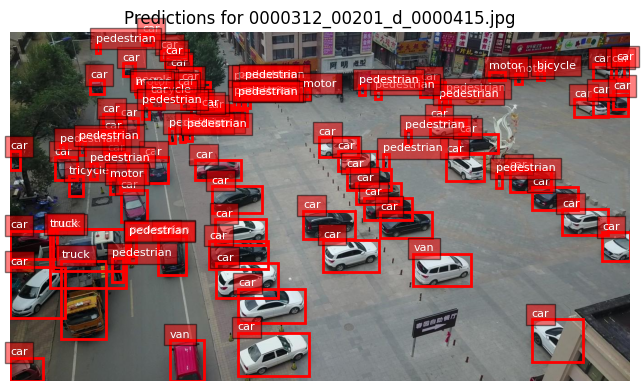

Predictions generated and saved.


In [17]:
# Evaluate the model on the validation set and generate result images with bounding boxes
import matplotlib.pyplot as plt
from PIL import Image
import os

# Load validation data
val_images_path = '../datasets/VisDrone/VisDrone2019-DET-val/images'

# Predict and visualize results for the first 2 images
test_images = [img for img in os.listdir(val_images_path) if img.endswith('.jpg')][:2]

# Iterate over the first two test images
for img_file in test_images:
    img_path = os.path.join(val_images_path, img_file)
    
    # Make predictions on the image
    results = model.predict(source=img_path, save=True)  # Save predictions as images

    # Plot the results
    img = Image.open(img_path)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predictions for {img_file}")

    # Show the bounding boxes and predictions
    for box in results[0].boxes:
        # Extract bounding box coordinates and label
        xmin, ymin, xmax, ymax = box.xyxy[0].tolist()
        label = results[0].names[int(box.cls[0])]
        
        # Plot bounding box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, edgecolor='red', fill=False, linewidth=2))
        plt.text(xmin, ymin - 5, f'{label}', color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))
    
    plt.show()

print("Predictions generated and saved.")
